In [1]:
import torch
import torchvision
import csv
import numpy as np
import torch.nn.functional as F
from torch import Tensor
from functools import partial
from typing import Any, Callable, List, Optional, Type, Union
import os
import pydicom
from PIL import Image
import random
import nibabel as nib
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch import nn
import sklearn.metrics
import matplotlib

device = "cuda" if torch.cuda.is_available() else "cpu"
device_name = 'F' #E
if device_name == 'F':
    torch.cuda.set_device(0)
else:
    torch.cuda.set_device(1)

In [2]:
batch_size=5

class Data_load:
    def __init__(self,num):
        self.len_=0
        self.x_data_name=[]
        self.x_data_test_name=[]
        self.normal_size=0
        self.mci_size=0
        self.ad_size=0
        self.test_len=0
        list_disease = ['Normal', 'MCI', 'AD']
        for i in range(num,num+1,1):
            for label_target, j in enumerate(list_disease):
                part_data_name=[]
                path = device_name+":/k-fold validation/"+str(i)+"/"+str(j)+"/"
                dir_list = os.listdir(path)
                len_dir=len(dir_list)
                for k in range(len_dir):
                    part_data_name.append([path+dir_list[k], label_target])
                self.x_data_test_name.append(part_data_name)
                if label_target == 0:
                    self.normal_size = len_dir
                elif label_target == 1:
                    self.mci_size = len_dir
                else:
                    self.ad_size = len_dir
                self.test_len+=len_dir
                        
        self.final_data_test_name=[]
        for i in range(len(self.x_data_test_name)):
            for j in range(len(self.x_data_test_name[i])):
                self.final_data_test_name.append(self.x_data_test_name[i][j])
        
    def out(self):
        return self.final_data_test_name

def training(data, batch_size):
    batch_total = len(data)//batch_size
    batch_na = len(data)%batch_size
    for i in range(batch_total+1):
        x_data=[]
        y_data=[]
        extra = []
        extra_final = []
        if i == batch_total:
            if batch_na == 0:
                break
            else:
                temp_data = data[i*batch_size:] 
        else:
            temp_data = data[i*batch_size:(i+1)*batch_size]
        for j in range(len(temp_data)): 
            img = nib.load(temp_data[j][0]+'/1/final/1_t1_final.mnc').get_fdata() 
            img = 255*img/img.max() 

            file = open(temp_data[j][0]+"/1/thickness/1_native_rms_rsl_tlink_30mm_left.txt", "r")
            lines = file.readlines()
            lines = list(map(float, lines))
            
            file = open(temp_data[j][0]+"/1/thickness/1_native_rms_rsl_tlink_30mm_right.txt", "r")
            lines_right = file.readlines()
            lines_right = list(map(float, lines_right))
            
            x_data.append(img)
            extra.append(lines +lines_right)
            
            if temp_data[j][1] == 0:  
                y_data.append([1,0,0]) 
            elif temp_data[j][1] == 1: 
                y_data.append([0,1,0]) 
            elif temp_data[j][1] == 2: 
                y_data.append([0,0,1])  

        x_data = torch.from_numpy(np.array(x_data)[:,np.newaxis,:,:,:]).type(torch.FloatTensor).to(device)
        y_data = torch.from_numpy(np.array(y_data)).type(torch.FloatTensor).to(device)
        extra = torch.from_numpy(np.array(extra)).type(torch.FloatTensor).to(device)

        yield (x_data, y_data, extra)

In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.layer_1 = nn.Conv3d(1,64,5,stride=2)
        self.layer_2 = nn.MaxPool3d(3)
        self.layer_3 = nn.Conv3d(64,128,3,stride=2)
        self.layer_4 = nn.MaxPool3d(3)
        self.layer_5 = nn.Conv3d(128,256,3,stride=1)
        self.layer_6 = nn.Linear(3072+81924,10000)
        self.layer_7 = nn.Linear(10000,3)
        self.flatten = torch.nn.Flatten()
        self.lrelu = nn.LeakyReLU()
        
    def forward(self, x, extra):
        x = self.lrelu(self.layer_1(x))
        x = self.layer_2(x)
        x = self.lrelu(self.layer_3(x))
        x = self.layer_4(x)
        x = self.lrelu(self.layer_5(x))
        x = self.flatten(x)
        x = torch.cat((x,extra),dim=1)
        x = self.lrelu(self.layer_6(x))
        x = self.layer_7(x)
        return x


In [4]:
total_final_pred=[]
total_final_y=[]

total_accuracy_sum=[]

total_precision = []
total_recall = []
total_specificity=[]
total_q = []
total_w = []
total_e = []

total_precision1 = []
total_recall1 = []
total_specificity1=[]
total_q1 = []
total_w1 = []
total_e1 = []

total_precision2 = []
total_recall2 = []
total_specificity2=[]
total_q2 = []
total_w2 = []
total_e2 = []

for tt in range(1,6,1):
    model = torch.load('./3D_CNN_thick'+str(tt)+'.pt', map_location='cuda:0')
    data = Data_load(tt)
    X_test = data.out()
    
    model.eval()
    with torch.no_grad():
        final_pred=[]
        final_y=[]

        accuracy_sum=0
        
        precision = 0
        recall = 0
        specificity=0
        q = 0
        w = 0
        e = 0

        precision1 = 0
        recall1 = 0
        specificity1=0
        q1 = 0
        w1 = 0
        e1 = 0

        precision2 = 0
        recall2 = 0
        specificity2=0
        q2 = 0
        w2 = 0
        e2 = 0
        
        for batch, (X, y, extra) in enumerate(training(X_test,batch_size)):
            pred = model(X, extra)
            pred_softmax = F.softmax(pred,dim=1)
     
            for i in range(y.shape[0]):
                final_pred.append(pred_softmax[i].to('cpu').numpy())
                final_y.append(y[i].to('cpu').numpy())

            for i in range(y.shape[0]):
                if torch.argmax(y[i], dim=0) == 0:
                    if torch.argmax(pred[i], dim=0) == 0:
                        accuracy_sum+= 1
                elif torch.argmax(y[i], dim=0) == 1:
                    if torch.argmax(pred[i], dim=0) == 1:
                        accuracy_sum+= 1
                elif torch.argmax(y[i], dim=0) == 2:
                    if torch.argmax(pred[i], dim=0) == 2:
                        accuracy_sum+= 1

                if torch.argmax(y[i], dim=0) == 0:
                    q+=1
                    if torch.argmax(pred[i], dim=0) == 0:
                        recall += 1
                if torch.argmax(pred[i], dim=0) == 0:
                    w+=1
                    if torch.argmax(y[i], dim=0) == 0:
                        precision +=1
                if torch.argmax(y[i], dim=0) != 0:
                    e+=1
                    if torch.argmax(pred[i], dim=0) != 0:
                        specificity +=1

                if torch.argmax(y[i], dim=0) == 1:
                    q1+=1
                    if torch.argmax(pred[i], dim=0) == 1:
                        recall1 += 1
                if torch.argmax(pred[i], dim=0) == 1:
                    w1+=1
                    if torch.argmax(y[i], dim=0) == 1:
                        precision1 +=1
                if torch.argmax(y[i], dim=0) != 1:
                    e1+=1
                    if torch.argmax(pred[i], dim=0) != 1:
                        specificity1 +=1

                if torch.argmax(y[i], dim=0) == 2:
                    q2+=1
                    if torch.argmax(pred[i], dim=0) == 2:
                        recall2 += 1
                if torch.argmax(pred[i], dim=0) == 2:
                    w2+=1
                    if torch.argmax(y[i], dim=0) == 2:
                        precision2 +=1
                if torch.argmax(y[i], dim=0) != 2:
                    e2+=1
                    if torch.argmax(pred[i], dim=0) != 2:
                        specificity2 +=1

        total_final_pred.append(final_pred)
        total_final_y.append(final_y)
        total_accuracy_sum.append(accuracy_sum)
        total_precision.append(precision)
        total_recall.append(recall)
        total_specificity.append(specificity)
        total_q.append(q)
        total_w.append(w)
        total_e.append(e)
        total_precision1.append(precision1)
        total_recall1.append(recall1)
        total_specificity1.append(specificity1)
        total_q1.append(q1)
        total_w1.append(w1)
        total_e1.append(e1)
        total_precision2.append(precision2)
        total_recall2.append(recall2)
        total_specificity2.append(specificity2)
        total_q2.append(q2)
        total_w2.append(w2)
        total_e2.append(e2)
        

print("Done!")


Done!


In [5]:

total_accuracy = []

total_normal_sensitivity = []
total_normal_precision = []
total_normal_specificity = []
total_normal_F1 = []
total_mci_sensitivity = []
total_mci_precision = []
total_mci_specificity = []
total_mci_F1 = []
total_ad_sensitivity = []
total_ad_precision = []
total_ad_specificity = []
total_ad_F1 = []
total_macro_sensitivity = []
total_macro_precision = []
total_macro_specificity = []
total_macro_F1 = []

total_pre_graph = []
total_pre_graph1 = []
total_pre_graph2 = []
total_re_graph = []
total_re_graph1 = []
total_re_graph2 = []
total_thresholds = []
total_thresholds1 = []
total_thresholds2 = []
total_auc_pr = []
total_auc_pr1 = []
total_auc_pr2 = []
    
total_fpr = []
total_tpr = []
total_thresholds_roc = []
total_auc_roc = []
total_fpr1 = []
total_tpr1 = []
total_thresholds_roc1 = []
total_auc_roc1 = []
total_fpr2 = []
total_tpr2 = []
total_thresholds_roc2 = []
total_auc_roc2 = []

for i in range(5):
    data = Data_load(i+1)
    try:
        recall_normal = 100*total_recall[i]/total_q[i]
        #print("Normal_sensitivity", round(recall_normal,1))
        total_normal_sensitivity.append(recall_normal)
    except:
        pass
    try:
        precision_normal = 100*total_precision[i]/total_w[i]
        #print("Normal_precision", round(precision_normal,1))
        total_normal_precision.append(precision_normal)
    except:
        pass
    try:
        specificity_normal = 100*total_specificity[i]/total_e[i]
        #print("Normal_specificity", round(specificity_normal,1))
        total_normal_specificity.append(specificity_normal)
    except:
        pass
    try:
        F1_normal = 2*recall_normal*precision_normal/(recall_normal+precision_normal)
        #print('Normal_F1-score', round(F1_normal,1))
        total_normal_F1.append(F1_normal)
    except:
        pass

    #print("-----------------")
    #print("test_average_loss",loss_sum)
    try:
        recall_mci = 100*total_recall1[i]/total_q1[i]
        #print("MCI_sensitivity", round(recall_mci,1))
        total_mci_sensitivity.append(recall_mci)
    except:
        pass
    try:
        precision_mci = 100*total_precision1[i]/total_w1[i]
        #print("MCI_precision", round(precision_mci,1))
        total_mci_precision.append(precision_mci)
    except:
        pass
    try:
        specificity_mci = 100*total_specificity1[i]/total_e1[i]
        #print("MCI_specificity", round(specificity_mci,1))
        total_mci_specificity.append(specificity_mci)
    except:
        pass
    try:
        F1_mci = 2*recall_mci*precision_mci/(recall_mci+precision_mci)
        #print('MCI_F1-score', round(F1_mci,1))
        total_mci_F1.append(F1_mci)
    except:
        pass

    #print("-----------------")
    #print("test_average_loss",loss_sum)
    try:
        recall_ad = 100*total_recall2[i]/total_q2[i]
        #print("AD_sensitivity", round(recall_ad,1))
        total_ad_sensitivity.append(recall_ad)
    except:
        pass
    try:
        precision_ad = 100*total_precision2[i]/total_w2[i]
        #print("AD_precision", round(precision_ad,1))
        total_ad_precision.append(precision_ad)
    except:
        pass
    try:
        specificity_ad = 100*total_specificity2[i]/total_e2[i]
        #print("AD_specificity", round(specificity_ad,1))
        total_ad_specificity.append(specificity_ad)
    except:
        pass
    try:
        F1_ad = 2*recall_ad*precision_ad/(recall_ad+precision_ad)
        #print('AD_F1-score', round(F1_ad,1))
        total_ad_F1.append(F1_ad)
    except:
        pass

    #print("-----------------")
    try:
        temp_accuracy = 100*total_accuracy_sum[i]/data.test_len
        #print("Total_Accuracy", round(temp_accuracy,1))
        total_accuracy.append(temp_accuracy)
    except:
        pass
    #print("-----------------")
    #print("test_average_loss",loss_sum)
    try:
        macro_recall = (recall_normal + recall_mci + recall_ad)/3
        #print("Macro_sensitivity", round(macro_recall,1))
        total_macro_sensitivity.append(macro_recall)
    except:
        pass
    try:
        macro_precision = (precision_normal + precision_mci + precision_ad)/3
        #print("Macro_precision", round(macro_precision,1))
        total_macro_precision.append(macro_precision)
    except:
        pass
    try:
        macro_specificity = (specificity_normal + specificity_mci + specificity_ad)/3
        #print("Macro_specificity", round(macro_specificity,1))
        total_macro_specificity.append(macro_specificity)
    except:
        pass
    try:
        macro_F1 = 2*macro_recall*macro_precision/(macro_recall+macro_precision)
        #print('Macro_F1-score', round(macro_F1,1))
        total_macro_F1.append(macro_F1)
    except:
        pass
    #print("-----------------")
    final_y = np.array(total_final_y[i]).astype(int)
    final_pred=np.array(total_final_pred[i])
    #print(final_y.shape)
    pre_graph, re_graph, thresholds = sklearn.metrics.precision_recall_curve(final_y[:,0],final_pred[:,0])
    auc_pr = sklearn.metrics.average_precision_score(final_y[:,0],final_pred[:,0])
    pre_graph1, re_graph1, thresholds1 = sklearn.metrics.precision_recall_curve(final_y[:,1],final_pred[:,1])
    auc_pr1 = sklearn.metrics.average_precision_score(final_y[:,1],final_pred[:,1])
    pre_graph2, re_graph2, thresholds2 = sklearn.metrics.precision_recall_curve(final_y[:,2],final_pred[:,2])
    auc_pr2 = sklearn.metrics.average_precision_score(final_y[:,2],final_pred[:,2])
    #print(type(pre_graph))
    total_pre_graph.append(pre_graph)
    total_pre_graph1.append(pre_graph1)
    total_pre_graph2.append(pre_graph2)
    total_re_graph.append(re_graph)
    total_re_graph1.append(re_graph1)
    total_re_graph2.append(re_graph2)
    total_thresholds.append(thresholds)
    total_thresholds1.append(thresholds1)
    total_thresholds2.append(thresholds2)
    total_auc_pr.append(auc_pr)
    total_auc_pr1.append(auc_pr1)
    total_auc_pr2.append(auc_pr2)
    
    fpr, tpr, thresholds_roc = sklearn.metrics.roc_curve(final_y[:,0],final_pred[:,0])
    auc_roc = sklearn.metrics.roc_auc_score(final_y[:,0],final_pred[:,0])
    fpr1, tpr1, thresholds_roc1 = sklearn.metrics.roc_curve(final_y[:,1],final_pred[:,1])
    auc_roc1 = sklearn.metrics.roc_auc_score(final_y[:,1],final_pred[:,1])
    fpr2, tpr2, thresholds_roc2 = sklearn.metrics.roc_curve(final_y[:,2],final_pred[:,2])
    auc_roc2 = sklearn.metrics.roc_auc_score(final_y[:,2],final_pred[:,2])
    
    total_fpr.append(fpr)
    total_tpr.append(tpr)
    total_thresholds_roc.append(thresholds_roc)
    total_auc_roc.append(auc_roc)
    total_fpr1.append(fpr1)
    total_tpr1.append(tpr1)
    total_thresholds_roc1.append(thresholds_roc1)
    total_auc_roc1.append(auc_roc1)
    total_fpr2.append(fpr2)
    total_tpr2.append(tpr2)
    total_thresholds_roc2.append(thresholds_roc2)
    total_auc_roc2.append(auc_roc2)
    

name_list = [\
"total_accuracy",\
"total_normal_sensitivity",\
"total_normal_precision",\
"total_normal_specificity",\
"total_normal_F1",\
"total_mci_sensitivity",\
"total_mci_precision",\
"total_mci_specificity",\
"total_mci_F1",\
"total_ad_sensitivity",\
"total_ad_precision",\
"total_ad_specificity",\
"total_ad_F1",\
"total_macro_sensitivity",\
"total_macro_precision",\
"total_macro_specificity",\
"total_macro_F1"]

list_list = [\
total_accuracy,\
total_normal_sensitivity,\
total_normal_precision,\
total_normal_specificity,\
total_normal_F1,\
total_mci_sensitivity,\
total_mci_precision,\
total_mci_specificity,\
total_mci_F1,\
total_ad_sensitivity,\
total_ad_precision,\
total_ad_specificity,\
total_ad_F1,\
total_macro_sensitivity,\
total_macro_precision,\
total_macro_specificity,\
total_macro_F1]

for num, i in enumerate(list_list):
    print(name_list[num],round(np.mean(i),1), "------------", round(np.std(i,ddof=1),1))

total_accuracy 65.6 ------------ 1.3
total_normal_sensitivity 83.1 ------------ 5.7
total_normal_precision 75.4 ------------ 2.7
total_normal_specificity 68.0 ------------ 6.2
total_normal_F1 78.9 ------------ 1.4
total_mci_sensitivity 44.6 ------------ 12.3
total_mci_precision 47.5 ------------ 4.7
total_mci_specificity 79.7 ------------ 7.3
total_mci_F1 45.1 ------------ 5.6
total_ad_sensitivity 46.1 ------------ 6.3
total_ad_precision 62.8 ------------ 8.1
total_ad_specificity 93.7 ------------ 2.8
total_ad_F1 52.4 ------------ 1.7
total_macro_sensitivity 57.9 ------------ 1.2
total_macro_precision 61.9 ------------ 3.0
total_macro_specificity 80.5 ------------ 0.8
total_macro_F1 59.8 ------------ 1.8


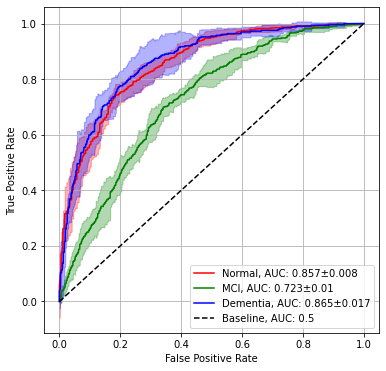

In [6]:
inter_fpr = np.insert(np.linspace(0,1,num=2000),0,0)
inter_tpr = []
inter_tpr1 = []
inter_tpr2 = []

for i in range(5):
    a = np.linspace(0,1,num=2000)
    b = np.insert(np.interp(a,total_fpr[i],total_tpr[i]),0,0)
    inter_tpr.append(b)

    a = np.linspace(0,1,num=2000)
    b = np.insert(np.interp(a,total_fpr1[i],total_tpr1[i]),0,0)
    inter_tpr1.append(b)
    
    a = np.linspace(0,1,num=2000)
    b = np.insert(np.interp(a,total_fpr2[i],total_tpr2[i]),0,0)
    inter_tpr2.append(b)

inter_con_up_tpr = []
inter_con_up_tpr1 = []
inter_con_up_tpr2 = []
inter_con_down_tpr = []
inter_con_down_tpr1 = []
inter_con_down_tpr2 = []
inter_aver = []
inter_aver1 = []
inter_aver2 = []

for i in range(2001):
    temp_temp_list = list()
    for j in range(5):
        temp_temp_list.append(inter_tpr[j][i])
    temp_aver = np.average(temp_temp_list)
    temp_std = np.std(temp_temp_list,ddof=1) ##
    interest_temp = 2.776*temp_std/np.sqrt(5)
    inter_con_up_tpr.append(temp_aver+interest_temp)
    inter_con_down_tpr.append(temp_aver-interest_temp)
    inter_aver.append(temp_aver)
    
    temp_temp_list = list()
    for j in range(5):
        temp_temp_list.append(inter_tpr1[j][i])
    #print(temp_temp_list)
    temp_aver = np.average(temp_temp_list)
    temp_std = np.std(temp_temp_list,ddof=1)
    interest_temp = 2.776*temp_std/np.sqrt(5)
    inter_con_up_tpr1.append(temp_aver+interest_temp)
    inter_con_down_tpr1.append(temp_aver-interest_temp)
    inter_aver1.append(temp_aver)
    
    temp_temp_list = list()
    for j in range(5):
        temp_temp_list.append(inter_tpr2[j][i])
    #print(temp_temp_list)
    temp_aver = np.average(temp_temp_list)
    temp_std = np.std(temp_temp_list,ddof=1)
    interest_temp = 2.776*temp_std/np.sqrt(5)
    inter_con_up_tpr2.append(temp_aver+interest_temp)
    inter_con_down_tpr2.append(temp_aver-interest_temp)
    inter_aver2.append(temp_aver)

random_roc_x = np.array([0,1])
random_roc_y = np.array([0,1])
fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_subplot()
auc_average = np.average(total_auc_roc)
auc_std = np.std(total_auc_roc,ddof=1)
auc_average1 = np.average(total_auc_roc1)
auc_std1 = np.std(total_auc_roc1,ddof=1)
auc_average2 = np.average(total_auc_roc2)
auc_std2 = np.std(total_auc_roc2,ddof=1)

line1=ax1.plot(inter_fpr, inter_aver, label='Normal, AUC: '+str(round(auc_average,3))+'±'+str(round(auc_std,3)), color='red')
line2=ax1.plot(inter_fpr, inter_aver1, label='MCI, AUC: '+str(round(auc_average1,3))+'±'+str(round(auc_std1,3)), color='green')
line3=ax1.plot(inter_fpr, inter_aver2, label='Dementia, AUC: '+str(round(auc_average2,3))+'±'+str(round(auc_std2,3)), color='blue')
line4=ax1.fill_between(inter_fpr,inter_con_up_tpr,inter_con_down_tpr,alpha=0.3, color='red')
line5=ax1.fill_between(inter_fpr,inter_con_up_tpr1,inter_con_down_tpr1,alpha=0.3, color='green')
line6=ax1.fill_between(inter_fpr,inter_con_up_tpr2,inter_con_down_tpr2,alpha=0.3, color='blue')
line7=ax1.plot(random_roc_x,random_roc_y, label='Baseline, AUC: '+str(0.5),linestyle = '--', color='black')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
lines = line1 + line2 + line3 + line7
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='lower right')
plt.grid(True)
plt.show()
plt.close()
   

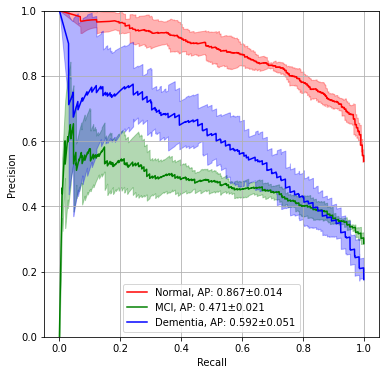

In [7]:

inter_fpr = np.linspace(0,1,num=2000)
inter_pre = []
inter_pre1 = []
inter_pre2 = []

for i in range(5):
    a = np.linspace(0,1,num=2000)
    b = np.interp(a,np.flip(total_re_graph[i]),np.flip(total_pre_graph[i]))
    inter_pre.append(b)

    a = np.linspace(0,1,num=2000)
    b = np.interp(a,np.flip(total_re_graph1[i]),np.flip(total_pre_graph1[i]))
    inter_pre1.append(b)
    
    a = np.linspace(0,1,num=2000)
    b = np.interp(a,np.flip(total_re_graph2[i]),np.flip(total_pre_graph2[i]))
    inter_pre2.append(b)

inter_con_up_pre = []
inter_con_up_pre1 = []
inter_con_up_pre2 = []
inter_con_down_pre = []
inter_con_down_pre1 = []
inter_con_down_pre2 = []
inter_aver_pre = []
inter_aver1_pre = []
inter_aver2_pre = []

for i in range(2000):
    temp_temp_list = list()
    for j in range(5):
        temp_temp_list.append(inter_pre[j][i])
    #print(temp_temp_list)
    temp_aver = np.average(temp_temp_list)
    temp_std = np.std(temp_temp_list,ddof=1)
    interest_temp = 2.776*temp_std/np.sqrt(5)
    inter_con_up_pre.append(temp_aver+interest_temp)
    inter_con_down_pre.append(temp_aver-interest_temp)
    inter_aver_pre.append(temp_aver)
    
    temp_temp_list = list()
    for j in range(5):
        temp_temp_list.append(inter_pre1[j][i])
    #print(temp_temp_list)
    temp_aver = np.average(temp_temp_list)
    temp_std = np.std(temp_temp_list,ddof=1)
    interest_temp = 2.776*temp_std/np.sqrt(5)
    inter_con_up_pre1.append(temp_aver+interest_temp)
    inter_con_down_pre1.append(temp_aver-interest_temp)
    inter_aver1_pre.append(temp_aver)
    
    temp_temp_list = list()
    for j in range(5):
        temp_temp_list.append(inter_pre2[j][i])
    #print(temp_temp_list)
    temp_aver = np.average(temp_temp_list)
    temp_std = np.std(temp_temp_list,ddof=1)
    interest_temp = 2.776*temp_std/np.sqrt(5)
    inter_con_up_pre2.append(temp_aver+interest_temp)
    inter_con_down_pre2.append(temp_aver-interest_temp)
    inter_aver2_pre.append(temp_aver)

fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_subplot()
auc_average = np.average(total_auc_pr)
auc_std = np.std(total_auc_pr,ddof=1)
auc_average1 = np.average(total_auc_pr1)
auc_std1 = np.std(total_auc_pr1,ddof=1)
auc_average2 = np.average(total_auc_pr2)
auc_std2 = np.std(total_auc_pr2,ddof=1)
line1=ax1.plot(inter_fpr, inter_aver_pre, label='Normal, AP: '+str(round(auc_average,3))+'±'+str(round(auc_std,3)), color='red')
line2=ax1.plot(inter_fpr, inter_aver1_pre, label='MCI, AP: '+str(round(auc_average1,3))+'±'+str(round(auc_std1,3)), color='green')
line3=ax1.plot(inter_fpr, inter_aver2_pre, label='Dementia, AP: '+str(round(auc_average2,3))+'±'+str(round(auc_std2,3)), color='blue')
line4=ax1.fill_between(inter_fpr,inter_con_up_pre,inter_con_down_pre,alpha=0.3, color='red')
line5=ax1.fill_between(inter_fpr,inter_con_up_pre1,inter_con_down_pre1,alpha=0.3, color='green')
line6=ax1.fill_between(inter_fpr,inter_con_up_pre2,inter_con_down_pre2,alpha=0.3, color='blue')
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
lines = line1 + line2 + line3
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='lower center')
plt.ylim(0,1.0)
plt.grid(True)
plt.show()
plt.close()
   